Fiding similar documents

In [1]:
import os
import time
import itertools
import collections
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "512m").\
        getOrCreate()

TARGET = 'sampledocs/'
documents = []
i = 0
for article in os.listdir(TARGET):
    if article == 'stopwords.txt':
        continue
    if article == '.ipynb_checkpoints':
        continue
    path = os.path.join(TARGET, article)
    print('id: ' + str(i) + ', doccument: ' + article)
    i += 1
    with open(path, 'r') as file:
        documents.append(file.read())
        
stopwords = []
with open(os.path.join(TARGET, 'stopwords.txt'), 'r') as file:
    for line in file:
        stopwords.append(line.strip())
        
        
for i, doc in enumerate(documents):
    doc = doc.strip().replace('\n', ' ').lower()
    for word in stopwords:
        doc = doc.replace(' '+word+' ', ' ')
    documents[i] = doc

print(f"Average char-length: \
{np.mean(np.array([len(x) for x in documents]))}")
print(f"Min char-length: {min(len(x) for x in documents)}")
print(f"Max char-length: {max(len(x) for x in documents)}")
print('Completed!')

id: 0, doccument: article5.txt
id: 1, doccument: article2.txt
id: 2, doccument: article1.txt
id: 3, doccument: article6.txt
id: 4, doccument: article3.txt
id: 5, doccument: article4.txt
Average char-length: 3627.1666666666665
Min char-length: 2412
Max char-length: 5873
Completed!


In [2]:
def getShingles(str1, K=5):
    d1 = set()
    for i in range(len(str1)-K):
        d1.add(str1[i:i+K])
    print(f"Found {len(d1)} unique shingles, out of {len(str1)} possible.")
    return d1
doc_shingles = [getShingles(s, 5) for s in documents]
print('Completed!')

Found 3953 unique shingles, out of 5873 possible.
Found 2091 unique shingles, out of 3291 possible.
Found 2060 unique shingles, out of 3009 possible.
Found 2245 unique shingles, out of 3505 possible.
Found 2782 unique shingles, out of 3673 possible.
Found 1918 unique shingles, out of 2412 possible.
Completed!


In [3]:
fullset = set.union(*doc_shingles)
shingle_dict = dict(zip(list(fullset),range(len(fullset))))
print(f"There are {len(shingle_dict)} shingles")
col_shingle = list(shingle_dict.keys())
num_col_shingle = len(col_shingle)
print('Completed!')

There are 7538 shingles
Completed!


In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

data = []
for i in range(len(documents)):
    potition = [j for j in range(num_col_shingle) if col_shingle[j] in doc_shingles[i]]
    sub_len = len(potition)
    data.append((i, Vectors.sparse(num_col_shingle, potition, [1.0] * sub_len)))
print('Completed!')

Completed!


In [5]:
from pyspark.ml.feature import MinHashLSH

dfA = spark.createDataFrame(data, ["id", "features"])

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(dfA)

print("Approximately joining dfA and dfB on distance smaller than 0.83:")


model.approxSimilarityJoin(dfA, dfA, 0.83, distCol="JaccardDistance")\
    .select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("JaccardDistance")).filter("datasetA.id < datasetB.id").show()
print('Completed!')

Approximately joining dfA and dfB on distance smaller than 0.83:
+---+---+------------------+
|idA|idB|   JaccardDistance|
+---+---+------------------+
|  0|  5|0.5998092058192226|
|  0|  2|0.6637777777777778|
|  1|  3|0.2962671905697446|
+---+---+------------------+

Completed!


In [6]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=2.0,
                                  numHashTables=3)
model = brp.fit(dfA)

print("Approximately joining dfA and dfB on Euclidean distance smaller than 58:")
model.approxSimilarityJoin(dfA, dfA, 58, distCol="EuclideanDistance")\
    .select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("EuclideanDistance")).filter("datasetA.id < datasetB.id").show()
print('Completed!')

Approximately joining dfA and dfB on Euclidean distance smaller than 58:
+---+---+------------------+
|idA|idB| EuclideanDistance|
+---+---+------------------+
|  1|  3|27.459060435491963|
|  0|  2|54.653453687758834|
|  0|  5|50.149775672479336|
|  0|  1| 57.39337940912697|
|  0|  3| 52.51666402200353|
|  3|  5| 53.91660226683428|
+---+---+------------------+

Completed!


Finding similar images

In [7]:
from matplotlib.image import imread

def pixelNormalize(x, n):
    band = 1 / n
    for i in range(0, n):
        if x >= band * i and x <= band * (i + 1):
            return i

TARGET = 'ALOI/'
imageAll = {}
for obj in os.listdir(TARGET):
    key = ''
    imagesNormalized = []
    images = []
    i = 0
    if obj == '.ipynb_checkpoints':
        continue
    for image in os.listdir(TARGET + obj):
        if image == '.ipynb_checkpoints':
            continue
        key += 'id: ' + str(i) + ', image: ' + image + '\n'
        i += 1
        image_sub = [0]*20**3
        img = imread(TARGET + obj + '/' + image)
        images.append(img)
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                R,G,B = img[row, col, :]
                R = pixelNormalize(R,20)
                G = pixelNormalize(G,20)
                B = pixelNormalize(B,20)
                idx = R * (20**2) + G * 20 + B
                image_sub[idx] += 1
        imagesNormalized.append(image_sub)
    imageAll[obj] = (key, imagesNormalized, images)
print('Completed!')

Completed!


In [12]:
for file, value in imageAll.items():
    print(value[0])
    imagesNormalized = value[1]
    data = []
    for i in range(len(imagesNormalized)):
        data.append((int(i), Vectors.dense(imagesNormalized[i]),))
    
    dfA = spark.createDataFrame(data, ["id", "features"])
    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
    model = mh.fit(dfA)

    print("Approximately joining dfA and dfB on Euclidean distance smaller than 0.55:")
    model.approxSimilarityJoin(dfA, dfA, 0.55, distCol="EuclideanDistance")\
       .filter("datasetA.id < datasetB.id").show()
    print('-----------------------------------------------------------------------------')
print('Completed!')

id: 0, image: 68_r0.png
id: 1, image: 86_r220.png
id: 2, image: 86_r355.png
id: 3, image: 86_r190.png

Approximately joining dfA and dfB on Euclidean distance smaller than 0.55:
+--------------------+--------------------+-------------------+
|            datasetA|            datasetB|  EuclideanDistance|
+--------------------+--------------------+-------------------+
|[1, [15856.0,6.0,...|[3, [14644.0,3.0,...|0.29778672032193154|
|[1, [15856.0,6.0,...|[2, [14561.0,7.0,...| 0.3380281690140845|
|[2, [14561.0,7.0,...|[3, [14644.0,3.0,...| 0.3313373253493014|
+--------------------+--------------------+-------------------+

-----------------------------------------------------------------------------
id: 0, image: 259_r0.png
id: 1, image: 231_r0.png
id: 2, image: 259_r290.png
id: 3, image: 259_r335.png

Approximately joining dfA and dfB on Euclidean distance smaller than 0.55:
+--------------------+--------------------+-------------------+
|            datasetA|            datasetB|  Euclid

Vector similarity for finding similar images

Brute force calculation

In [9]:
def cossim(u,v):
    norm = np.linalg.norm(u)*np.linalg.norm(v)
    cosine = u@v/norm
    ang = np.arccos(cosine)
    return 1-ang/np.pi

def display_multiple_img(image1, image2):
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(image1)
    ax.set_title('Image A')

    ax = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(image2)
    ax.set_title('Image B')

def lsh_euclidean(A, b, r, thresh):
  """ A must be an (N,D) matrix consisting of N real valued euclidean vectors.
  Args:
    A: the (N,D) matrix of vectors to with which to find similar pairs
    b: the number of bands
    r: the number of rows per band
    thresh: a float value [-1,1] determining the required cosine similarity threshold
  Returns:
    a set of pairs with requisite similarity. Contains no false positives, but may omit False negatives
  """
  N, D = A.shape
  n = b*r
  
  # Compute signature matrix
  R = A@np.random.randn(D, n)
  S = np.where(R>0, 1, 0)

  # Break into bands
  S = np.split(S, b, axis=1)

  # column vector to convert binary vector to integer e.g. (1,0,1)->5
  binary_column = 2**np.arange(r).reshape(-1,  1)

  # convert each band into a single integer, 
  # i.e. convert band matrices to band columns
  S = np.hstack([M@binary_column for M in S])

  # Every value in the matrix represents a hash bucket assignment
  # For every bucket in row i, add index i to that bucket
  d = collections.defaultdict(set)
  with np.nditer(S,flags=['multi_index']) as it:
      for x in it:
          d[int(x)].add(it.multi_index[0])

  # For every bucket, find all pairs. These are the LSH pairs.
  candidate_pairs = set()
  for k,v in d.items():
      if len(v) > 1:
          for pair in itertools.combinations(v, 2):
              candidate_pairs.add(tuple(sorted(pair)))

  # Finally, perform the actually similarity computation
  # to weed out false positives
  lsh_pairs = set()
  for (i, j) in candidate_pairs:
      if cossim(A[i],A[j]) > thresh:
          lsh_pairs.add((i, j))
          
  return lsh_pairs

id: 0, image: 280_r150.png
id: 1, image: 555_r180.png
id: 2, image: 394_r330.png
id: 3, image: 63_r355.png
id: 4, image: 38_r20.png
id: 5, image: 63_r80.png
id: 6, image: 394_r0.png
id: 7, image: 555_r5.png
id: 8, image: 879_r0.png
id: 9, image: 278_r155.png
id: 10, image: 15_r5.png
id: 11, image: 280_r325.png
id: 12, image: 15_r300.png
id: 13, image: 977_r0.png
id: 14, image: 967_r0.png
id: 15, image: 278_r330.png
id: 16, image: 38_r330.png
id: 17, image: 879_r320.png
id: 18, image: 977_r295.png
id: 19, image: 967_r220.png

Discovered pairs: 10 pairs
Pair: (0, 11),	Similarity: 0.9853.
Pair: (1, 7),	Similarity: 0.9809.
Pair: (2, 6),	Similarity: 0.9824.
Pair: (3, 5),	Similarity: 0.9872.
Pair: (4, 16),	Similarity: 0.9794.
Pair: (8, 17),	Similarity: 0.9918.
Pair: (9, 15),	Similarity: 0.9897.
Pair: (10, 12),	Similarity: 0.9875.
Pair: (13, 18),	Similarity: 0.9869.
Pair: (14, 19),	Similarity: 0.9916.
Brute force calculation time: 0.5156736373901367
-------------------------------------------

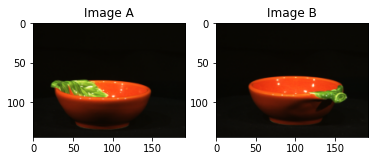

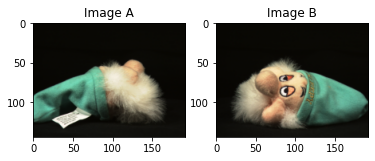

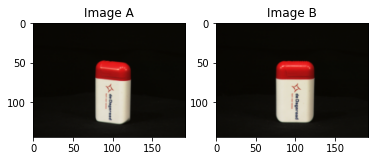

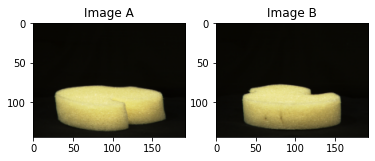

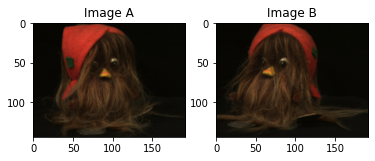

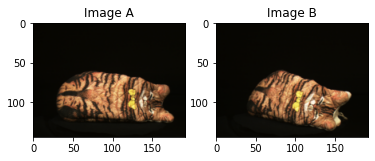

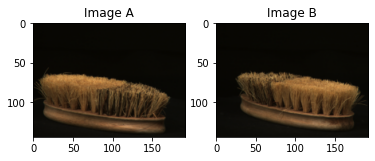

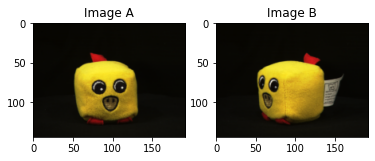

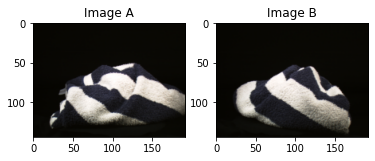

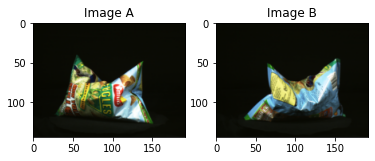

In [10]:
thresh = 0.979

for file, value in imageAll.items():
    if file != 'mix':
        continue
    print(value[0])
    imagesNormalized = np.array(value[1])
    images = value[2]
    true_pairs_dict = {}
    start = time.time()
    for (i,u),(j,v) in itertools.combinations([(i,x) for i,x in enumerate(imagesNormalized)],2):
        val = cossim(u,v)
        if val > thresh:
            true_pairs_dict[(i,j)] = val

    # save just the keys without the values. Easier to compare later to LSH
    true_pairs = set(true_pairs_dict.keys())
    print(f"Discovered pairs: " + str(len(true_pairs)) + ' pairs')
    for k, v in true_pairs_dict.items():
        print(f"Pair: {k},\tSimilarity: {v:.4f}.")
        display_multiple_img(images[k[0]], images[k[1]])
    bruteForceTime = time.time() - start
    print(f"Brute force calculation time: {bruteForceTime}")
    print('-----------------------------------------------------------------------------')
print('Completed!')

id: 0, image: 280_r150.png
id: 1, image: 555_r180.png
id: 2, image: 394_r330.png
id: 3, image: 63_r355.png
id: 4, image: 38_r20.png
id: 5, image: 63_r80.png
id: 6, image: 394_r0.png
id: 7, image: 555_r5.png
id: 8, image: 879_r0.png
id: 9, image: 278_r155.png
id: 10, image: 15_r5.png
id: 11, image: 280_r325.png
id: 12, image: 15_r300.png
id: 13, image: 977_r0.png
id: 14, image: 967_r0.png
id: 15, image: 278_r330.png
id: 16, image: 38_r330.png
id: 17, image: 879_r320.png
id: 18, image: 977_r295.png
id: 19, image: 967_r220.png

Discovered pairs: 10 pairs
Brute force calculation time: 0.3671119213104248
LSH fasten more Brute force: 1.40
{(2, 6), (9, 15), (14, 19), (10, 12), (4, 16), (0, 11), (13, 18), (1, 7), (8, 17), (3, 5)}
-----------------------------------------------------------------------------
Completed!


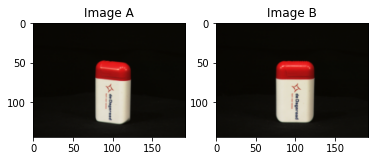

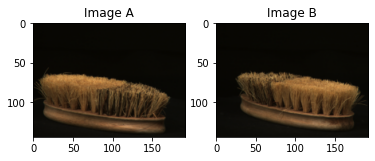

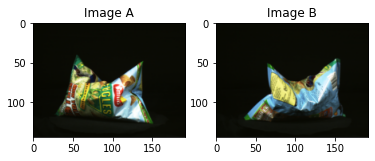

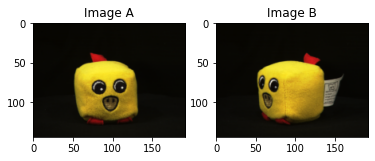

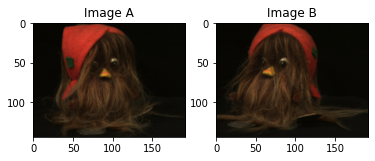

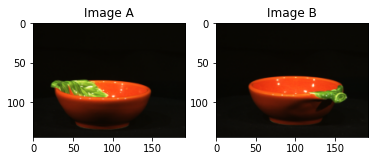

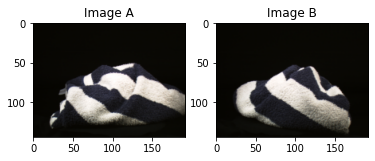

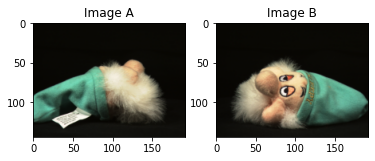

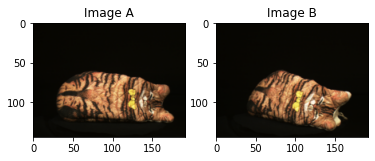

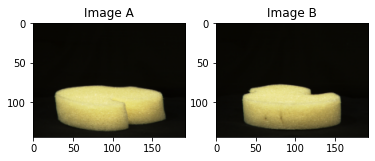

In [11]:
thresh = 0.979
for file, value in imageAll.items():
    if file != 'mix':
        continue
    print(value[0])
    imagesNormalized = np.array(value[1])
    images = value[2]
    start = time.time()
    lshPairs = lsh_euclidean(imagesNormalized, 100, 10, thresh)
    print(f"Discovered pairs: " + str(len(lshPairs)) + ' pairs')
    lshTime = time.time() - start
    print(f"Brute force calculation time: {lshTime}")
    print(f"LSH fasten more Brute force: {bruteForceTime / lshTime:.2f}")
    print(lshPairs)
    for a, b in lshPairs:
        display_multiple_img(images[a], images[b])
    print('-----------------------------------------------------------------------------')
print('Completed!')